# Gensim Word2Vec Tutorial professor Leonardo


<img src="https://images.freeimages.com/images/large-previews/2b9/letters-1-yes-1188348.jpg" alt="drawing" width="350"/>

# Vamos a implementar um modelo word2vector passo a passo

#  Word2Vec:

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

[[1]](#References:)


## proposta do exercicio:
Como eu disse antes, este tutorial foca no uso correto do pacote Word2Vec da libray Gensim; portanto, não vou explicar os conceitos e idéias por trás do Word2Vec aqui..

## breve explicação :

O Word2Vec foi apresentado em dois [artigos] (# Material-for-mais-em-deeps-enting :) entre setembro e outubro de 2013, por uma equipe de pesquisadores do Google. Junto com os artigos, os pesquisadores publicaram sua implementação em C. A implementação do Python foi feita logo após o primeiro artigo, por [Gensim] (https://radimrehurek.com/gensim/index.html).

A suposição subjacente do Word2Vec é que duas palavras que compartilham contextos semelhantes também compartilham um significado semelhante e, conseqüentemente, uma representação vetorial semelhante do modelo. Por exemplo: "cachorro", "filhote" e "filhote" são frequentemente usados ​​em situações semelhantes, com palavras próximas como "bom", "fofo" ou "fofo" e, de acordo com o Word2Vec, eles compartilharão uma representação vetorial semelhante . <br>

Partindo dessa suposição, o Word2Vec pode ser usado para descobrir as relações entre as palavras em um conjunto de dados, calcular a similaridade entre elas ou usar a representação vetorial dessas palavras como entrada para outras aplicações, como classificação de texto ou agrupamento.

# Getting Started

## Setting up the environment:

`python==3.6.3`

Libraries used:
 * `xlrd==1.1.0`: https://pypi.org/project/xlrd/
 * `spaCy==2.0.12`: https://spacy.io/usage/
 * `gensim==3.4.0`: https://radimrehurek.com/gensim/install.html
 * `scikit-learn==0.19.1`: http://scikit-learn.org/stable/install.html
 * `seaborn==0.8`: https://seaborn.pydata.org/installing.html

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

<img src="https://upload.wikimedia.org/wikipedia/commons/4/44/Logo_The_Simpsons.svg" alt="drawing" width="400"/>

## Os dados:
Se escolheu brincar com o roteiro dos Simpsons, tanto porque amo os Simpsons quanto porque com mais de 150 mil linhas de diálogos, o conjunto de dados era substancial!

Este conjunto de dados contém os personagens, locais, detalhes do episódio e linhas do roteiro para aproximadamente 600 episódios dos Simpsons, que datam de 1989. Ele pode ser encontrado aqui: https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data (~25MB)

# Pré-processando

Mantemos apenas duas colunas:
* `raw_character_text`: o personagem que fala (pode ser útil ao monitorar as etapas de pré-processamento)
* `speak_words`: o texto bruto da linha de diálogo

Não mantemos `normalized_text` porque queremos fazer nosso próprio pré-processamento.

Você pode encontrar o arquivo resultante aqui: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons

In [2]:
df = pd.read_csv('simpsons_dataset.csv')
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


Os valores ausentes vêm da parte do script onde algo acontece, mas sem diálogo. Por exemplo "(Springfield Elementary School: EXT. ELEMENTARY - SCHOOL PLAYGROUND - AFTERNOON)"

In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

Removing the missing values:

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

INFO - 13:47:19: NumExpr defaulting to 2 threads.


raw_character_text    0
spoken_words          0
dtype: int64

## Limpeza:
Estamos lematizando e removendo as palavras irrelevantes e os caracteres não alfabéticos de cada linha do diálogo.

In [6]:
nlp = spacy.load('en', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Remove caracteres não alfabéticos:

In [7]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

Aproveitando o atributo spaCy .pipe () para acelerar o processo de limpeza:

In [8]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_threads=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 1.07 mins


Coloque os resultados em um DataFrame para remover valores ausentes e duplicatas:

In [9]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85964, 1)

## Bigrams:
Estamos usando o pacote Gensim Phrases para detectar automaticamente frases comuns (bigramas) de uma lista de frases.
https://radimrehurek.com/gensim/models/phrases.html

A principal razão de fazermos isso é pegar palavras como "mr_burns" ou "bart_simpson"!

In [10]:
from gensim.models.phrases import Phrases, Phraser

INFO - 13:48:26: 'pattern' package not found; tag filters are not available for English


As `Phrases()` takes a list of list of words as input:

In [11]:
sent = [row.split() for row in df_clean['clean']]

Cria as frases relevantes da lista de frases:

In [12]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 13:48:26: collecting all words and their counts
INFO - 13:48:26: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 13:48:26: PROGRESS: at sentence #10000, processed 63561 words and 52816 word types
INFO - 13:48:26: PROGRESS: at sentence #20000, processed 130943 words and 99866 word types
INFO - 13:48:26: PROGRESS: at sentence #30000, processed 192972 words and 138532 word types
INFO - 13:48:26: PROGRESS: at sentence #40000, processed 249842 words and 172659 word types
INFO - 13:48:26: PROGRESS: at sentence #50000, processed 311265 words and 208566 word types
INFO - 13:48:27: PROGRESS: at sentence #60000, processed 373588 words and 243702 word types
INFO - 13:48:27: PROGRESS: at sentence #70000, processed 436441 words and 278740 word types
INFO - 13:48:27: PROGRESS: at sentence #80000, processed 497829 words and 311886 word types
INFO - 13:48:27: collected 330804 word types from a corpus of 537160 words (unigram + bigrams) and 85964 sentences
INFO - 13:48:27: us

In [13]:
bigram = Phraser(phrases)

INFO - 13:48:27: source_vocab length 330804
INFO - 13:48:30: Phraser built with 126 phrasegrams


Transforme o corpus com base nos bigramas detectados:

In [14]:
sentences = bigram[sent]

##Palavras mais frequentes:
Principalmente uma verificação de integridade da eficácia da lematização, remoção de palavras irrelevantes e adição de bigramas.

In [15]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

30178

In [16]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'right', 'look', 'want', 'come']

# Treinar o modelo
## Implementação Gensim Word2Vec:
Usamos a implementação Gensim de word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [17]:
import multiprocessing

from gensim.models import Word2Vec

## Por que separo o treinamento do modelo em 3 etapas:
Prefiro separar o treinamento em 3 etapas distintas para maior clareza e monitoramento.
1. `Word2Vec ()`:
> Nesta primeira etapa, configurei os parâmetros do modelo um por um. <br> Eu não forneço o parâmetro `sentenças` e, portanto, deixo o modelo não inicializado, propositalmente.
2. `.build_vocab ()`:
> Aqui, ele constrói o vocabulário a partir de uma sequência de frases e, assim, inicializa o modelo. <br> Com os registros, posso acompanhar o progresso e, mais importante ainda, o efeito de `min_count` e` sample` no corpus de palavras. Percebi que esses dois parâmetros, e em particular `sample`, têm uma grande influência sobre o desempenho de um modelo. Exibir ambos permite um gerenciamento mais preciso e fácil de sua influência.
3. `.train ()`:
> Finalmente, treina o modelo. <br>
Os registros aqui são principalmente úteis para monitoramento, certificando-se de que nenhuma thread seja executada instantaneamente.

In [18]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

# Os parametros:

* `min_count` <font color = 'purple'> = </font> <font color = 'green'> int </font> - Ignora todas as palavras com frequência absoluta total inferior a esta - (2, 100)


* `window` <font color = 'purple'> = </font> <font color = 'green'> int </font> - A distância máxima entre a palavra atual e a prevista em uma frase. Por exemplo. palavras `janela` à esquerda e palavras` janela` à esquerda do nosso alvo - (2, 10)


* `size` <font color = 'purple'> = </font> <font color = 'green'> int </font> - Dimensionalidade dos vetores de recursos. - (50, 300)


* `sample` <font color = 'purple'> = </font> <font color = 'green'> float </font> - O limite para configurar quais palavras de alta frequência são reduzidas aleatoriamente. Altamente influente. - (0, 1e-5)


* `alpha` <font color = 'purple'> = </font> <font color = 'green'> float </font> - A taxa de aprendizagem inicial - (0,01, 0,05)


* `min_alpha` <font color = 'purple'> = </font> <font color = 'green'> float </font> - A taxa de aprendizagem cairá linearmente para` min_alpha` conforme o treinamento progride. Para defini-lo: alpha - (min_alpha * epochs) ~ 0,00


* `negative` <font color = 'purple'> = </font> <font color = 'green'> int </font> - Se> 0, a amostragem negativa será usada, o int para negativo especifica quantos" ruído palavras "deve ser afogada. Se definido como 0, nenhuma amostra negativa é usada. - (5, 20)


* `workers` <font color = 'purple'> = </font> <font color = 'green'> int </font> - Use esses vários threads de trabalho para treinar o modelo (= treinamento mais rápido com máquinas multicore)

In [19]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Construindo a Tabela de Vocabulário:
O Word2Vec exige que construamos a tabela de vocabulário (simplesmente digerindo todas as palavras e filtrando as palavras únicas e fazendo algumas contagens básicas com elas):

In [20]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:48:32: collecting all words and their counts
INFO - 13:48:32: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 13:48:32: PROGRESS: at sentence #10000, processed 61718 words, keeping 9558 word types
INFO - 13:48:32: PROGRESS: at sentence #20000, processed 127351 words, keeping 14506 word types
INFO - 13:48:33: PROGRESS: at sentence #30000, processed 187829 words, keeping 17619 word types
INFO - 13:48:33: PROGRESS: at sentence #40000, processed 243332 words, keeping 20385 word types
INFO - 13:48:33: PROGRESS: at sentence #50000, processed 303182 words, keeping 22878 word types
INFO - 13:48:33: PROGRESS: at sentence #60000, processed 363940 words, keeping 25200 word types
INFO - 13:48:33: PROGRESS: at sentence #70000, processed 425408 words, keeping 27401 word types
INFO - 13:48:34: PROGRESS: at sentence #80000, processed 485464 words, keeping 29275 word types
INFO - 13:48:34: collected 30178 word types from a corpus of 523700 raw words and 85964 sentence

Time to build vocab: 0.04 mins


## Treinamento do modelo:
_Parâmetros do treinamento: _
* `total_examples` <font color = 'purple'> = </font> <font color = 'green'> int </font> - Contagem de frases;
* `epochs` <font color = 'purple'> = </font> <font color = 'green'> int </font> - Número de iterações (épocas) no corpus - [10, 20, 30]

In [21]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 13:48:35: training model with 1 workers on 3319 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 13:48:36: EPOCH 1 - PROGRESS: at 29.42% examples, 57724 words/s, in_qsize 0, out_qsize 0
INFO - 13:48:37: EPOCH 1 - PROGRESS: at 65.21% examples, 62171 words/s, in_qsize 0, out_qsize 0
INFO - 13:48:38: EPOCH 1 - PROGRESS: at 99.32% examples, 63812 words/s, in_qsize 1, out_qsize 0
INFO - 13:48:38: worker thread finished; awaiting finish of 0 more threads
INFO - 13:48:38: EPOCH - 1 : training on 523700 raw words (198820 effective words) took 3.1s, 63886 effective words/s
INFO - 13:48:39: EPOCH 2 - PROGRESS: at 31.39% examples, 63623 words/s, in_qsize 0, out_qsize 0
INFO - 13:48:40: EPOCH 2 - PROGRESS: at 67.17% examples, 65655 words/s, in_qsize 0, out_qsize 0
INFO - 13:48:41: worker thread finished; awaiting finish of 0 more threads
INFO - 13:48:41: EPOCH - 2 : training on 523700 raw words (199218 effective words) took 3.0s, 66281 effective words/s


Time to train the model: 1.53 mins


In [22]:
w2v_model.init_sims(replace=True)

INFO - 13:50:06: precomputing L2-norms of word weight vectors


# Explorando o modelo
## Mais semelhante a:

Aqui, pediremos ao nosso modelo para encontrar a palavra mais semelhante a alguns dos personagens mais icônicos dos Simpsons!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/02/Homer_Simpson_2006.png/revision/latest?cb=20091207194310" alt="drawing" width="130"/>

Vamos ver o que temos para o personagem principal do show:

In [23]:
w2v_model.wv.most_similar(positive=["homer"])

[('bongo', 0.7874407768249512),
 ('rude', 0.7664246559143066),
 ('wife', 0.7633519768714905),
 ('marge', 0.7502470016479492),
 ('snuggle', 0.7494360208511353),
 ('gee', 0.7399948835372925),
 ('crummy', 0.7358750700950623),
 ('hammock', 0.7313786745071411),
 ('attract', 0.7281444072723389),
 ('sorry', 0.7280675172805786)]

_Uma pequena precisão aqui: _ <br>
O conjunto de dados são as linhas de diálogo dos Simpsons; portanto, quando olhamos para as palavras mais semelhantes de "homer", ** não ** necessariamente obtemos seus familiares, traços de personalidade ou mesmo suas palavras mais citáveis. Não, entendemos o que outros personagens (como Homer não costuma se referir a si mesmo na 3ª pessoa) disseram junto com "homer", como ele se sente ou parece ("deprimido"), onde ele está ("rede"), ou com quem ("marge").

Vamos ver o que o bigrama "homer_simpson" nos dá por comparação:

In [24]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('congratulation', 0.7767180800437927),
 ('recent', 0.756017804145813),
 ('council', 0.7550948262214661),
 ('pleased', 0.7520171403884888),
 ('easily', 0.7490992546081543),
 ('robert', 0.7364720106124878),
 ('committee', 0.735478937625885),
 ('fellow', 0.7342870235443115),
 ('erotic', 0.7341390252113342),
 ('governor', 0.7322831153869629)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/0b/Marge_Simpson.png/revision/latest?cb=20180626055729" alt="drawing" width="150"/>
E a Marge agora?

In [25]:
w2v_model.wv.most_similar(positive=["marge"])

[('convince', 0.7807130813598633),
 ('rude', 0.7684463262557983),
 ('grownup', 0.7576817274093628),
 ('fault', 0.757023811340332),
 ('sorry', 0.7561575174331665),
 ('becky', 0.7534768581390381),
 ('hammock', 0.7510963678359985),
 ('homer', 0.7502470016479492),
 ('raccoon', 0.7487740516662598),
 ('sweetie', 0.7485724687576294)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/65/Bart_Simpson.png/revision/latest?cb=20180319061933" alt="drawing" width="100"/>

Lagora o bart:

In [26]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8355005979537964),
 ('homework', 0.79459547996521),
 ('surprised', 0.7883856892585754),
 ('mom', 0.7864275574684143),
 ('convince', 0.7754257917404175),
 ('strangle', 0.7677710652351379),
 ('upset', 0.7653093338012695),
 ('substitute', 0.7638247013092041),
 ('typical', 0.762986421585083),
 ('hearing', 0.7620980739593506)]

Parece que está fazendo sentido!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/9d/Groundskeeper_Willie.png/revision/latest?cb=20130424154035" alt="drawing" width="150"/>

e agora o escoces willy

## Similaridades:
Aqui, veremos como duas palavras são semelhantes:



<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/6c/MaggieSimpson.PNG/revision/latest?cb=20180314210204" alt="drawing" width="100"/>

In [27]:
w2v_model.wv.similarity('maggie', 'baby')

0.711927

Maggie is indeed the most renown baby in the Simpsons!

In [28]:
w2v_model.wv.similarity('bart', 'nelson')

0.65399677

Bart e Nelson, embora amigos, não sejam tão próximos, faz sentido!

## Odd-One-Out:

Aqui, pedimos ao nosso modelo que nos dê a palavra que não pertence à lista!

Entre Jimbo, Milhouse e Kearney, quem é aquele que  é um valentão?

In [29]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 13:50:07: vectors for words {'kearney'} are not present in the model, ignoring these words
/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'jimbo'

In [30]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'nelson'



<img src="https://vignette.wikia.nocookie.net/simpsons/images/4/40/Picture0003.jpg/revision/latest?cb=20110623042517" alt="drawing" width="200"/>

Por último, mas não menos importante, como é a relação entre Homer e suas duas cunhadas?

In [31]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'homer'

Droga, eles realmente não gostam de você Homer!

## Diferença de analogia:
Qual palavra é para mulher como homer é para marge?

In [32]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

[('admire', 0.6785337328910828),
 ('wife', 0.6342260241508484),
 ('ought', 0.6182737350463867)]

In [33]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

[('parent', 0.744362473487854),
 ('lisa', 0.7373144626617432),
 ('pregnant', 0.7276972532272339)]

Lisa is Bart's sister, her male counterpart!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/5/57/Lisa_Simpson2.png/revision/latest?cb=20180319000458" alt="drawing" width="100"/>

### Visualizações t-SNE:
t-SNE é um algoritmo de redução de dimensionalidade não linear que tenta representar dados dimensionais elevados e as relações subjacentes entre vetores em um espaço de dimensão inferior. <br>
Aqui está um bom tutorial sobre isso: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [34]:
!pip install scikit-learn==0.19.0

In [35]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
sklearn.__version__

'0.19.0'

Nosso objetivo nesta seção é plotar nossos vetores de 300 dimensões em gráficos bidimensionais e ver se podemos localizar padrões interessantes. <br>
Para isso, usaremos a implementação t-SNE do scikit-learn.

Para tornar as visualizações mais relevantes, examinaremos as relações entre uma palavra de consulta (em <font color = 'red'> ** vermelho ** </font>), suas palavras mais semelhantes no modelo (em <cor da fonte = "blue"> ** blue ** </font>) e outras palavras do vocabulário (em <font color = 'green'> ** verde ** </font>).

In [36]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=50).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    


## 10 palavras mais semelhantes vs. 8 palavras aleatórias:
Vamos comparar onde a representação vetorial de Homer, suas 10 palavras mais semelhantes do modelo, bem como 8 palavras aleatórias, se encontram em um gráfico 2D:

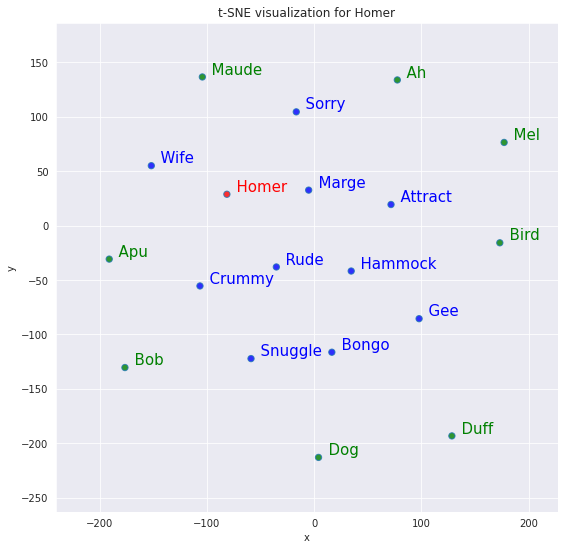

In [37]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Curiosamente, as 10 palavras mais semelhantes a Homer acabam em torno dele, assim como Apu e (show à parte) Bob, dois personagens recorrentes.

## 10 palavras mais semelhantes vs. 10 mais diferentes

Desta vez, vamos comparar onde a representação vetorial de Maggie e suas 10 palavras mais semelhantes do modelo se compara à representação vetorial das 10 palavras mais diferentes de Maggie:

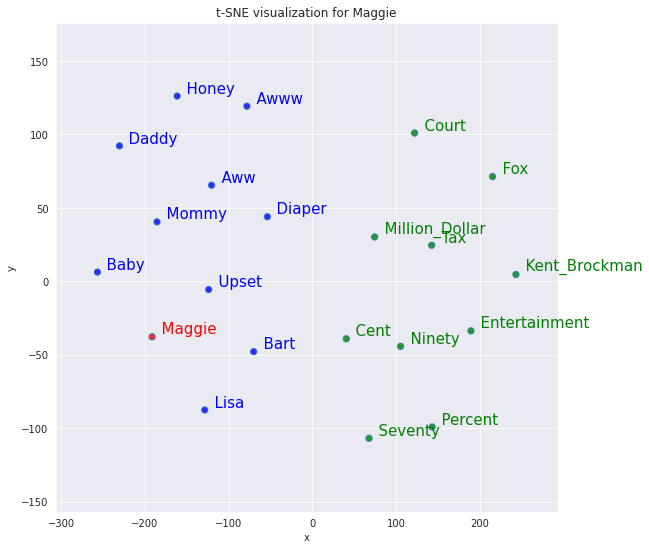

In [38]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

Arrumado! Maggie e suas palavras mais semelhantes formam um grupo distinto das palavras mais diferentes, é um enredo realmente encorajador!

